In [23]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tablepyxl import tablepyxl
from copy import deepcopy
import numpy as np
import io
from PIL import Image
import fitz


In [24]:
from paddleocr import PPStructure,save_structure_res
from paddleocr.ppstructure.recovery.recovery_to_doc import sorted_layout_boxes, convert_info_docx

In [80]:
doc = fitz.open('Sample\GCA RE.pdf')
page = doc[0]
pix = page.get_pixmap(dpi=300)
byte = io.BytesIO(pix.pil_tobytes(format="JPEG"))
image_pil = Image.open(byte)
gca_arr = np.asarray(image_pil)

In [81]:
doc = fitz.open('Sample\IOL.pdf')
page = doc[0]
pix = page.get_pixmap(dpi=300)
byte = io.BytesIO(pix.pil_tobytes(format="JPEG"))
image_pil = Image.open(byte)
iol_arr = np.asarray(image_pil)

In [82]:
# read image table
# path = 'Sample/IOL.png'
# img = cv2.imread(path)
# img = cv2.resize(img, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[600:795, 80:520]
# plt.imshow(img)

In [83]:
# read circle
# path = 'Sample/S__33579013.jpg'
# img = cv2.imread(path)
# img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[400:800 , 750:1050]
# plt.imshow(img)

In [84]:
# ocr circle
# path = 'Sample/out.png'
# img = cv2.imread(path)
# # img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[1530:1850, 800:1200]
# # plt.imshow(img)
# img = Image.fromarray(img)

In [85]:
tmp = {
    "name1": [
        {
            "id": "circle_right",
            "type": "image",
            "box_pos": [300, 100, 900, 250]  # [x1, y1, x2, y2]
        },
        {
            "id": "circle_left",
            "type": "image",
            "box_pos": [1550, 1600, 1900, 1850]
        }
    ],
    "name2": [
        {
            "id": "name",
            "type": "text",
            "box_pos": [127.440, 741.671, 204.817, 749.921]
        },
        {
            "id": "id",
            "type": "text",
            "box_pos": [127.440, 721.511, 164.136, 729.761]
        },
        {
            "id": "DOB",
            "type": "text",
            "box_pos": [127.440, 708.551, 164.119, 716.801]
        }
    ]
}

data_input = [{
        "template_name": tmp['name1'],
        "image": image_pil,
        "page": 1,
}]

In [86]:
# load model
def load_model():
    """
    load model from paddleocr (PPStructure)

    Returns:
        tabular engine model
    """
    table_engine = PPStructure(recovery=True, lang='en', layout=False)
    return table_engine

def predict(table_engine, image):
    """
    predict table from image

    Args:
        table_engine: tabular engine model
        image: input image

    Returns:
        result of prediction
    """
    result = table_engine(image)
    return result

def process_result(result):
    """
    process result from prediction

    Args:
        result: result of prediction

    Returns:
        dataframe from result
    """
    result_cp = deepcopy(result)
    df_ls = []
    for region in result_cp:
        # if html are available
        if 'html' in region['res']:
            # try to convert html to dataframe with tablepyxl
            try:
                html = region['res']['html']
                wb = tablepyxl.document_to_workbook(html)
                output = io.BytesIO()
                wb.save(output)
                output.seek(0)
                df = pd.read_excel(output, header=None)
                df = df.dropna(how='all').dropna(axis=1, how='all')
                df_ls.append(df)
            # if tablepyxl give error, try to convert html to dataframe with pandas
            except:
                print('except')
                df = pd.read_html(result[0]['res']['html'])[0]
                df = df.dropna(how='all').dropna(axis=1, how='all')
                df_ls.append(df)
                pass
        else:
            # empty dataframe
            df = pd.DataFrame()
            df_ls.append(df)
            
    # concat dataframe if there are more than 1 dataframe  
    if len(df_ls) == 0:
        return pd.DataFrame()
    else:    
        return pd.concat(df_ls, axis=0) 

def inference(data_input, engine):
    """
    inference from input data

    Args:
        data_input (dict): input data
        engine : engine model

    Returns:
        dataframe from result    
    """
    df_predict_ls = []
    for page_index in range(len(data_input)):
        page = data_input[page_index]
        # image_path = page['path']
        # image = cv2.imread(image_path)
        image = page['image']
        image = np.asarray(image)
        for box_index in range(len(page['template_name'])):
            x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
            roi_image = image[y1:y2, x1:x2]
            result = predict(engine, roi_image)
            df_predict = process_result(result)
            # columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
            # df_predict.columns = columns_ls
            id_column = page['template_name'][box_index]['id']
            index_columns = df_predict.columns.get_level_values(0)
            df_predict.columns = pd.MultiIndex.from_product([[id_column], index_columns])
            df_predict_ls.append(df_predict)
            
    return pd.concat(df_predict_ls, axis=1).reset_index(drop=True)
    # return df_predict_ls


In [87]:
table_engine = PPStructure(recovery=True, lang='en', layout=False) # table_gca, tabel, 
# layout = PPStructure(recovery=True, lang='en', layout=True) #  circle_partial, circle, tabel
# engine = PPStructure(recovery=True, lang='en')
# engine = PPStructure(lang="en")

[2023/12/15 06:47:54] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_vali

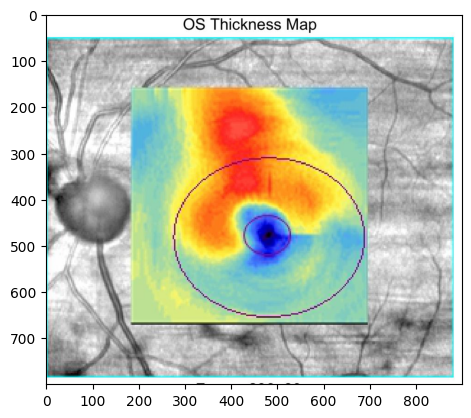

In [90]:
table_gca = gca_arr[1850:2500,900:1800]
non_text_gca = gca_arr[600:1400,1500:2400]
line_gca = gca_arr[100:250,300:900]
column_gca =  gca_arr[1500:1900,1200:1500]# layout = false
circle_partial = gca_arr[1600:1850,1550:1900] # layout = true
circle = gca_arr[1525:1850,1500:1900] # layout = true
table = iol_arr[1300:1900,200:]
plt.imshow(non_text_gca)

In [91]:
result = table_engine(non_text_gca)
result_cp = deepcopy(result)
df_ls = []
for region in result_cp:
    # if html are available
    if 'html' in region['res']:
        # try to convert html to dataframe with tablepyxl
        try:
            html = region['res']['html']
            wb = tablepyxl.document_to_workbook(html)
            output = io.BytesIO()
            wb.save(output)
            output.seek(0)
            df = pd.read_excel(output, header=None, displayed_only=False)
            df = df.dropna(how='all').dropna(axis=1, how='all')
            df_ls.append(df)
        # if tablepyxl give error, try to convert html to dataframe with pandas
        except:
            print('except')
            df = pd.read_html(result[0]['res']['html'])[0]
            df = df.dropna(how='all').dropna(axis=1, how='all')
            df_ls.append(df)
            pass
    else:
        # empty dataframe
        df = pd.DataFrame()
        df_ls.append(df)


[2023/12/15 06:48:29] ppocr DEBUG: dt_boxes num : 1, elapse : 0.6132252216339111
[2023/12/15 06:48:29] ppocr DEBUG: rec_res num  : 1, elapse : 0.1709742546081543
except


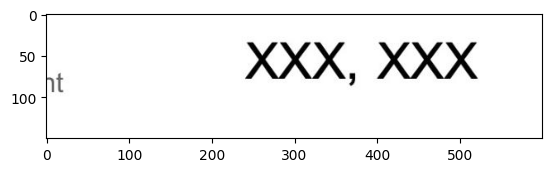

[2023/12/15 05:26:43] ppocr DEBUG: dt_boxes num : 2, elapse : 0.09233498573303223
[2023/12/15 05:26:43] ppocr DEBUG: rec_res num  : 2, elapse : 0.26009345054626465
  circle_right          
             0         2
1          NaN  XXX, XXX
3           nt       NaN


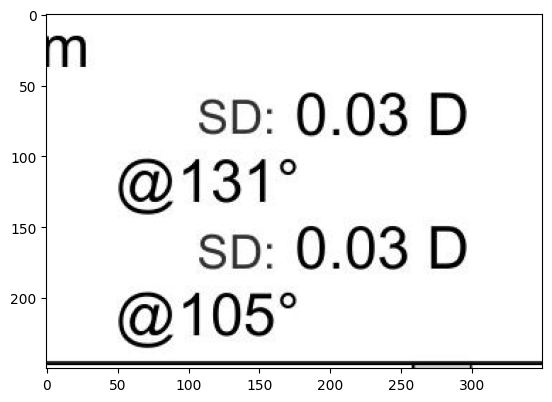

[2023/12/15 05:26:44] ppocr DEBUG: dt_boxes num : 5, elapse : 0.10452580451965332
[2023/12/15 05:26:45] ppocr DEBUG: rec_res num  : 5, elapse : 0.6793739795684814
except
   circle_left           
    Unnamed: 1 Unnamed: 2
1          NaN  SD:0.03 D
3         @131        NaN
7    SD:0.03 D        NaN
11        @105        NaN


In [56]:
engine = table_engine
df_predict_ls = []

for page_index in range(len(data_input)):
    page = data_input[page_index]
    image = page['image']
    image = np.asarray(image)
    for box_index in range(len(page['template_name'])):
        x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
        roi_image = image[y1:y2, x1:x2]
        plt.imshow(roi_image)
        plt.show()
        result = predict(engine, roi_image)
        df_predict = process_result(result)
        id_column = page['template_name'][box_index]['id']
        index_columns = df_predict.columns.get_level_values(0)
        df_predict.columns = pd.MultiIndex.from_product([[id_column], index_columns])
        df_predict_ls.append(df_predict)
        print(df_predict)
        


In [66]:
pd.concat(df_predict_ls + [pd.DataFrame()])

circle_right           circle_left           
              0         2  Unnamed: 1 Unnamed: 2
1           NaN  XXX, XXX         NaN        NaN
3            nt       NaN         NaN        NaN
1           NaN       NaN         NaN  SD:0.03 D
3           NaN       NaN        @131        NaN
7           NaN       NaN   SD:0.03 D        NaN
11          NaN       NaN        @105        NaN

In [65]:
df_predict_ls + [pd.DataFrame([])]

[  circle_right          
              0         2
 1          NaN  XXX, XXX
 3           nt       NaN,
    circle_left           
     Unnamed: 1 Unnamed: 2
 1          NaN  SD:0.03 D
 3         @131        NaN
 7    SD:0.03 D        NaN
 11        @105        NaN,
 Empty DataFrame
 Columns: []
 Index: []]

In [42]:
pd.DataFrame([])

""


In [ ]:
df_predict_ls = []
for page_index in range(len(data_input)):
    page = data_input[page_index]
    # image_path = page['path']
    # image = cv2.imread(image_path)
    image = page['image']
    image = np.asarray(image)
    for box_index in range(len(page['template_name'])):
        x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
        roi_image = image[y1:y2, x1:x2]
        result = predict(engine, roi_image)
        df_predict = process_result(result)
        # columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
        # df_predict.columns = columns_ls
        id_column = page['template_name'][box_index]['id']
        index_columns = df_predict.columns.get_level_values(0)
        df_predict.columns = pd.MultiIndex.from_product([[id_column], index_columns])
        df_predict_ls.append(df_predict)
        
pd.concat(df_predict_ls, axis=1)

In [533]:
inference(data_input, table_engine)

[2023/12/15 00:38:47] ppocr DEBUG: dt_boxes num : 25, elapse : 0.19721055030822754
[2023/12/15 00:38:50] ppocr DEBUG: rec_res num  : 25, elapse : 3.3267219066619873
[2023/12/15 00:38:51] ppocr DEBUG: dt_boxes num : 5, elapse : 0.0925295352935791
[2023/12/15 00:38:52] ppocr DEBUG: rec_res num  : 5, elapse : 0.6473047733306885
except


circle_right                                                              \
              0                             1                 2           3   
0         Name:                      xXX, XXX               NaN          OD   
1           ID:                      12345678        Exam Date:  10/20/2023   
2          DOB:                      1/1/2000        Exam Time:     9:56 AM   
3       Gender:                          Male    Serial Number:  5000-19931   
4           NaN  Technician: Operator, Cirrus  Signal Strength:       10/10   
6           NaN                           NaN               NaN         NaN   
7           NaN                           NaN               NaN         NaN   
12          NaN                           NaN               NaN         NaN   

                      circle_left                        
             4      5  Unnamed: 0 Unnamed: 1 Unnamed: 2  
0           os  ZEISS        80.0        NaN       73.0  
1   10/20/2023   CZMI        80.0        NaN        NaN  
2      9:57 AM    NaN         NaN        NaN        NaN  
3   5000-19931    NaN         NaN        NaN        NaN  
4        10/10    NaN         NaN        NaN        NaN  
6          NaN    NaN        77.0        NaN        NaN  
7          NaN    NaN        77.0        NaN       77.0  
12         NaN    NaN         NaN       75.0        NaN

In [ ]:
# save_folder = "output"
# img_path = "test2"
# result = table_engine(roi_image)
# save_structure_res(result, save_folder,os.path.basename(img_path).split('.')[0])